In [53]:
import pickle

df_sentiment_score=pickle.load(open('../src/data/sentiment_score_df.pkl','rb'))

In [54]:
df_sentiment_score.head()

,text,stars,embeddings,sentiment
0,Ate at the bar late one evening. The food was...,3.0,"[0.02110215, 0.015082884, 0.027772486, 0.04898...",0
1,ive gone here more than 10 times. the first f...,2.0,"[0.053978473, -0.005075182, 0.03789233, 0.0295...",-1
2,"Went here Saturday for drag brunch, we had 8 p...",3.0,"[0.05708591, -0.007079023, 0.02999837, 0.03157...",0
3,Turns out they randomly close the pool down wh...,3.0,"[0.01065718, 0.014424983, 0.042207252, 0.02751...",0
4,"Totally awesome experience. Very New Orleans ""...",3.0,"[0.029420882, 0.032237433, 0.026742732, 0.0395...",0


In [55]:
from pyathena import connect
import pandas as pd
import configparser

In [56]:
config = configparser.ConfigParser()
config.read('../access_keys_shreya.cfg')
AWS_ACCESS_KEY = config.get('aws', 'aws_access_key')
AWS_SECRET_KEY = config.get('aws', 'aws_secret_key')

In [58]:
from six.moves.urllib.parse import quote_plus
from sqlalchemy.engine import create_engine

SCHEMA_NAME = "yelp"
S3_STAGING_DIR = "s3://sairin.yelp.dataset/dataset"
AWS_REGION = "us-west-1"
conn_str = (
    "awsathena+rest://{aws_access_key_id}:{aws_secret_access_key}@"
    "athena.{region_name}.amazonaws.com:443/"
    "{schema_name}?s3_staging_dir={s3_staging_dir}&work_group=primary"
)


# Create the SQLAlchemy connection. Note that you need to have pyathena installed for this.
engine = create_engine(
    conn_str.format(
        aws_access_key_id=quote_plus(AWS_ACCESS_KEY),
        aws_secret_access_key=quote_plus(AWS_SECRET_KEY),
        region_name=AWS_REGION,
        schema_name=SCHEMA_NAME,
        s3_staging_dir=quote_plus(S3_STAGING_DIR),
    )
)
athena_connection = engine.connect()


In [59]:
query_business = """
        SELECT * 
        FROM yelp.philadelphia_top_restaurant
        """


In [60]:
runBlock = True
if runBlock:
    df_restaurant_philadelphia = pd.read_sql(query_business, athena_connection)
    df_restaurant_philadelphia.to_pickle('../src/data/top_restaurant_philadelphia.pkl')

In [61]:
df_restaurant_philadelphia = pd.read_pickle('../src/data/top_restaurant_philadelphia.pkl')

In [62]:
df_restaurant_philadelphia.head()

,review_id,business_id,stars,text,name,address,city,state,latitude,longitude
0,XddpIPiKwKb9KoCclSF6rw,eMiN8nm70jjKg8izikVWDA,5.0,Great place! We went here after attending th...,Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511
1,a4cme5BXWaV5-umuOn9JaQ,eMiN8nm70jjKg8izikVWDA,1.0,"RUDE staff, DIRTY seating area, OK food, NO ex...",Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511
2,l0-tupdk7x2BySqPo3aNYg,eMiN8nm70jjKg8izikVWDA,4.0,This is a great place to catch a bite and rela...,Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511
3,JIdkx8A59z_WAtZKVc1YtA,eMiN8nm70jjKg8izikVWDA,1.0,A very unprofessional staff organizing the cro...,Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511
4,e3wkqC-NeZCf8FBO8OXQCg,eMiN8nm70jjKg8izikVWDA,5.0,Ate at the airport location. Not only was the...,Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511


In [63]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/sairindhri/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [101]:
from sentence_transformers import SentenceTransformer
# import tqdm.notebook as tq
from tqdm import tqdm
from time import sleep
import numpy as np


# Load the pre-trained model
bert_model = SentenceTransformer('all-MiniLM-L6-v2')

def generate_mean_embedding(row):
    review = row
    review_sentances = nltk.sent_tokenize(review)

    embeddings = bert_model.encode(review_sentances)

    mean_embeddings =  np.mean(embeddings, axis=0)
    return mean_embeddings

def generate_bert_embeddings(review_text):
   
    mean_embeddings=generate_mean_embedding(review_text)
    return mean_embeddings
    



# df_balanced_data.to_pickle("intermediate_data/bert_generated_embeddings_balanced_dataframe.pkl")

In [67]:
text=df_restaurant_philadelphia['text'][0]
text

'Great place!  We went here after attending  the phillies baseball game (they won!). The CrabFries are perfectly seasoned and crispy and come with 2 cups of the awesome white cheese. The lobster sandwich was very good- a good amount of lobster and delicious bread.  Hamburgers were good too and medium rare was perfect.  Tons of screens to watch the games and a Deejay. We will definitely return.'

In [146]:

text=df_restaurant_philadelphia['text'][0]
embedding=generate_bert_embeddings(text)
embedding

array([-1.24268448e-02,  2.80168653e-02,  2.51132157e-02, -1.77652501e-02,
       -3.81044708e-02, -7.01929396e-03, -3.15790921e-02, -1.43214716e-02,
       -2.41303593e-02, -1.26093416e-03, -1.31603470e-02, -4.27906448e-03,
        2.68610734e-02, -2.86502931e-02,  1.25390664e-03, -3.80587168e-02,
        5.84061518e-02, -5.39815687e-02,  3.83089371e-02, -3.71749289e-02,
       -2.10139751e-02,  1.16378386e-02,  9.75144748e-03, -6.69243920e-04,
       -2.75258552e-02,  3.63229737e-02,  6.82506757e-03,  2.53317654e-02,
       -2.92926561e-02, -2.42917351e-02, -3.55410427e-02,  2.97436472e-02,
       -1.15284408e-02,  6.15830999e-03, -8.32603779e-03,  1.98601540e-02,
        2.88779438e-02, -7.00917169e-02,  3.58197354e-02,  3.89400609e-02,
        7.68359425e-03,  1.87180899e-02,  1.52312806e-02,  3.67928967e-02,
       -4.07065414e-02, -1.43688004e-02, -3.16923782e-02, -1.22171994e-02,
        6.41981736e-02,  9.07968823e-03,  3.99726555e-02,  2.06381269e-02,
       -6.65890845e-03, -

In [142]:
svm_model = pickle.load(open('../src/data/svm_sentiment_prediction_model.pkl','rb'))

def predict_sentiment_score(embedding):
    embedding_new = np.array(embedding).reshape(1, -1)
    sentiment_score = svm_model.predict(embedding_new)
    return sentiment_score[0]


In [71]:
embedding.shape

(384,)

# Creating restaurant for displaying


In [143]:
unique_business_ids = df_restaurant_philadelphia['business_id'].unique()[:5]
unique_business_ids

array(['eMiN8nm70jjKg8izikVWDA', 'nIAbuktMEzVjT4P9pG89rQ',
       'bLJP0fVgscuUQy0hE_CRXA', 'BxfvdHqETU8jWYUjx5OL2A',
       'rVGxva6cx2eID4ghDLVHJg'], dtype=object)

In [144]:
df_business = [pd.DataFrame]*5

df_business[0]=df_restaurant_philadelphia[df_restaurant_philadelphia['business_id']=='eMiN8nm70jjKg8izikVWDA']
df_business[1]=df_restaurant_philadelphia[df_restaurant_philadelphia['business_id']=='nIAbuktMEzVjT4P9pG89rQ']
df_business[2]=df_restaurant_philadelphia[df_restaurant_philadelphia['business_id']=='bLJP0fVgscuUQy0hE_CRXA']
df_business[3]=df_restaurant_philadelphia[df_restaurant_philadelphia['business_id']=='BxfvdHqETU8jWYUjx5OL2A']
df_business[4]=df_restaurant_philadelphia[df_restaurant_philadelphia['business_id']=='rVGxva6cx2eID4ghDLVHJg']



In [145]:
for idx in range(5):
    df_business[idx]['embedding']=df_business[idx]['text'].apply(generate_bert_embeddings)
    print("bert embedding generated for {}".format(idx))
    df_business[idx]['sentiment_score']=df_business[idx]['embedding'].apply(predict_sentiment_score)
    print("sentiment_score generated for {}".format(idx))



/var/folders/69/1v36mqw920lcphv2lfprw2sw0000gp/T/ipykernel_62287/108818384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business[idx]['embedding']=df_business[idx]['text'].apply(generate_bert_embeddings)


bert embedding generated for 0


/var/folders/69/1v36mqw920lcphv2lfprw2sw0000gp/T/ipykernel_62287/108818384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business[idx]['sentiment_score']=df_business[idx]['embedding'].apply(predict_sentiment_score)


sentiment_score generated for 0


/var/folders/69/1v36mqw920lcphv2lfprw2sw0000gp/T/ipykernel_62287/108818384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business[idx]['embedding']=df_business[idx]['text'].apply(generate_bert_embeddings)


bert embedding generated for 1


/var/folders/69/1v36mqw920lcphv2lfprw2sw0000gp/T/ipykernel_62287/108818384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business[idx]['sentiment_score']=df_business[idx]['embedding'].apply(predict_sentiment_score)


sentiment_score generated for 1


/var/folders/69/1v36mqw920lcphv2lfprw2sw0000gp/T/ipykernel_62287/108818384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business[idx]['embedding']=df_business[idx]['text'].apply(generate_bert_embeddings)


bert embedding generated for 2


/var/folders/69/1v36mqw920lcphv2lfprw2sw0000gp/T/ipykernel_62287/108818384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business[idx]['sentiment_score']=df_business[idx]['embedding'].apply(predict_sentiment_score)


sentiment_score generated for 2


/var/folders/69/1v36mqw920lcphv2lfprw2sw0000gp/T/ipykernel_62287/108818384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business[idx]['embedding']=df_business[idx]['text'].apply(generate_bert_embeddings)


bert embedding generated for 3


/var/folders/69/1v36mqw920lcphv2lfprw2sw0000gp/T/ipykernel_62287/108818384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business[idx]['sentiment_score']=df_business[idx]['embedding'].apply(predict_sentiment_score)


sentiment_score generated for 3


/var/folders/69/1v36mqw920lcphv2lfprw2sw0000gp/T/ipykernel_62287/108818384.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business[idx]['embedding']=df_business[idx]['text'].apply(generate_bert_embeddings)


bert embedding generated for 4
sentiment_score generated for 4


/var/folders/69/1v36mqw920lcphv2lfprw2sw0000gp/T/ipykernel_62287/108818384.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_business[idx]['sentiment_score']=df_business[idx]['embedding'].apply(predict_sentiment_score)


In [230]:
df_business[3].head()


,review_id,business_id,stars,text,name,address,city,state,latitude,longitude,embedding,sentiment_score
10,TzCiflLbZoYP9ryhbK678w,BxfvdHqETU8jWYUjx5OL2A,4.0,I've eaten here many times and have yet to tas...,Shake Shack,2000 Sansom St,Philadelphia,PA,39.951226,-75.173789,"[-0.0033024387, -0.03515473, 0.026377466, 0.01...",-1
14,I9g7ol3NonVONj93nksivg,BxfvdHqETU8jWYUjx5OL2A,1.0,Passed by Shake Shake and my toddler had a yea...,Shake Shack,2000 Sansom St,Philadelphia,PA,39.951226,-75.173789,"[-0.025101455, 0.003079403, 0.021813577, 0.044...",-1
25,00s2AMMtji3FsUKJpCLScg,BxfvdHqETU8jWYUjx5OL2A,5.0,"Incredible burgers. Simple, but high quality.\...",Shake Shack,2000 Sansom St,Philadelphia,PA,39.951226,-75.173789,"[-0.038198497, 0.003956022, 0.010840289, 0.007...",1
1960,s741Pn7bQ4Qe50KEY5KpHQ,BxfvdHqETU8jWYUjx5OL2A,1.0,Went in for a burger and a shake and it took 3...,Shake Shack,2000 Sansom St,Philadelphia,PA,39.951226,-75.173789,"[0.054636978, -0.009686653, 0.04717759, 0.0017...",-1
1964,v_GqvXaxS87UXQPg0AjI1Q,BxfvdHqETU8jWYUjx5OL2A,4.0,Sometimes you just need a burger and hand-spun...,Shake Shack,2000 Sansom St,Philadelphia,PA,39.951226,-75.173789,"[-0.015349579, -0.033461098, 0.026980186, 0.03...",1


In [177]:
df_ratings = []
for i in range(5):

    df_rating = df_business[i].groupby('business_id').agg({'stars': 'mean', 'name': 'first', 'address': 'first', 'city': 'first', 'state': 'first', 'latitude': 'first', 'longitude': 'first'}).reset_index()
    df_rating.rename(columns={'stars': 'average_star'}, inplace=True)
    df_ratings.append(df_rating)
# Concatenate the individual DataFrames into a single DataFrame
restaurant_sentiment_final = pd.concat(df_ratings, ignore_index=True)

restaurant_sentiment_final

,business_id,average_star,name,address,city,state,latitude,longitude
0,eMiN8nm70jjKg8izikVWDA,3.407960,Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511
1,nIAbuktMEzVjT4P9pG89rQ,4.072819,Buddakan,325 Chestnut St,Philadelphia,PA,39.948919,-75.147167
2,bLJP0fVgscuUQy0hE_CRXA,4.185129,Xiandu Thai,1119 Walnut St,Philadelphia,PA,39.949051,-75.159888
3,BxfvdHqETU8jWYUjx5OL2A,3.657602,Shake Shack,2000 Sansom St,Philadelphia,PA,39.951226,-75.173789
4,rVGxva6cx2eID4ghDLVHJg,3.623214,1225Raw Sushi and Sake Lounge,1225 Sansom St,Philadelphia,PA,39.949849,-75.161549


In [178]:
def count_sentiment_scores(column):
    counts = {
        1: 0,
        0: 0,
        -1: 0
    }
    for score in column:
        counts[score] += 1
    return counts

In [179]:
sentiment_counts_business = [{}]*5
for i in range(5):
    sentiment_counts_business[i] = count_sentiment_scores(df_business[i]['sentiment_score'])
    print(sentiment_counts_business[i])

{1: 362, 0: 54, -1: 187}
{1: 1160, 0: 187, -1: 246}
{1: 509, 0: 53, -1: 97}
{1: 522, 0: 70, -1: 217}
{1: 354, 0: 91, -1: 115}


In [180]:
# Add sentiment counts to the final DataFrame
restaurant_sentiment_final['positive_reviews'] = [counts[1] for counts in sentiment_counts_business]
restaurant_sentiment_final['neutral_reviews'] = [counts[0] for counts in sentiment_counts_business]
restaurant_sentiment_final['negative_reviews'] = [counts[-1] for counts in sentiment_counts_business]

restaurant_sentiment_final

,business_id,average_star,name,address,city,state,latitude,longitude,positive_reviews,neutral_reviews,negative_reviews
0,eMiN8nm70jjKg8izikVWDA,3.407960,Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511,362,54,187
1,nIAbuktMEzVjT4P9pG89rQ,4.072819,Buddakan,325 Chestnut St,Philadelphia,PA,39.948919,-75.147167,1160,187,246
2,bLJP0fVgscuUQy0hE_CRXA,4.185129,Xiandu Thai,1119 Walnut St,Philadelphia,PA,39.949051,-75.159888,509,53,97
3,BxfvdHqETU8jWYUjx5OL2A,3.657602,Shake Shack,2000 Sansom St,Philadelphia,PA,39.951226,-75.173789,522,70,217
4,rVGxva6cx2eID4ghDLVHJg,3.623214,1225Raw Sushi and Sake Lounge,1225 Sansom St,Philadelphia,PA,39.949849,-75.161549,354,91,115


In [181]:
restaurant_sentiment_final
pickle.dump(restaurant_sentiment_final,open('../src/data/restaurant_sentiment_final.pkl','wb'))

# Dataset Creation For Aspect Based Sentiment Analysis

In [255]:
import openai
import json
import tiktoken
import time

def num_tokens_from_messages(messages, model="gpt-3.5-turbo-0301"):
   """Returns the number of tokens used by a list of messages."""
   try:
       encoding = tiktoken.encoding_for_model(model)
   except KeyError:
       print("Warning: model not found. Using cl100k_base encoding.")
       encoding = tiktoken.get_encoding("cl100k_base")
   if model == "gpt-3.5-turbo":
       print("Warning: gpt-3.5-turbo may change over time. Returning num tokens assuming gpt-3.5-turbo-0301.")
       return num_tokens_from_messages(messages, model="gpt-3.5-turbo-0301")
   elif model == "gpt-4":
       print("Warning: gpt-4 may change over time. Returning num tokens assuming gpt-4-0314.")
       return num_tokens_from_messages(messages, model="gpt-4-0314")
   elif model == "gpt-3.5-turbo-0301":
       tokens_per_message = 4  # every message follows <|start|>{role/name}\n{content}<|end|>\n
       tokens_per_name = -1  # if there's a name, the role is omitted
   elif model == "gpt-4-0314":
       tokens_per_message = 3
       tokens_per_name = 1
   else:
       raise NotImplementedError(f"""num_tokens_from_messages() is not implemented for model {model}. See https://github.com/openai/openai-python/blob/main/chatml.md for information on how messages are converted to tokens.""")
   num_tokens = 0
   for message in messages:
       num_tokens += tokens_per_message
       for key, value in message.items():
           num_tokens += len(encoding.encode(value))
           if key == "name":
               num_tokens += tokens_per_name
   num_tokens += 3  # every reply is primed with <|start|>assistant<|message|>
   return num_tokens

class SentimentAnalyzer:
   def __init__(self, openai_api_key=None, temperature=0.7):
       if openai_api_key:
           openai.api_key = openai_api_key
       openai.api_base = "http://subhagato-desktop.local:5001/v1"
       self.temperature = temperature
       self.system_message = '''You are a language expert for restaurant reviews that generates Aspect Based Sentiment for a restaurant review in the form of a JSON string with the following format: {"Food Quality" : [-1, 0, 1], "Price": [-1, 0, 1], "Ambiance": [-1, 0, 1], "Service": [-1, 0, 1], "Comfort": [-1, 0, 1]} given a review. The values will be -1 if the sentiment is negative, it will be 0 if nothing is mentioned about the topic, will be 1 if the sentiment is positive'''
       self.sample_data = []
       self.conversation = [{"role": "system", "content": self.system_message}]
       self.token_count = self.count_tokens()

   def addSampleData(self, review, sentiment):
       self.sample_data.append((review, sentiment))
       self.conversation.append({"role": "user", "content": review})
       self.conversation.append({"role": "assistant", "content": sentiment})
       # Count tokens in review and sentiment
       self.token_count = self.count_tokens()

   def deleteSamples(self):
       self.sample_data = []
       self.conversation = [{"role": "system", "content": self.system_message}]
       self.token_count = self.count_tokens()

   def analyze_sentiment(self, review):
       self.conversation.append({"role": "user", "content": review})
       self.token_count = self.count_tokens()

       response = openai.ChatCompletion.create(
         model="gpt-3.5-turbo",
         messages=self.conversation,
         temperature=self.temperature
       )

       sentiment = response['choices'][0]['message']['content']
       del self.conversation[-1]
       print("sentiment: {}".format(sentiment))

       try:
          sentiment_json = json.loads(sentiment)
       except:
          sentiment_json = json.loads("{}")
       return sentiment_json
   
   def analyze_sentiment_completions(self, review):
        self.conversation.append({"role": "user", "content": review})
        self.token_count = self.count_tokens()

        # Convert the conversation history into a single string
        conversation_string = self.system_message + "\n"
        for message in self.conversation[1:]:
            conversation_string += f"{message['role'].upper()}: {message['content']}\n"

        conversation_string += "ASSISTANT:"

        response = openai.Completion.create(
            model="text-davinci-003",
            prompt=conversation_string,
            temperature=self.temperature,
            stop="USER:"
        )

        sentiment = response['choices'][0]['text'].strip()
        del self.conversation[-1]

        print("sentiment: {}".format(sentiment))

        try:
            sentiment_json = json.loads(sentiment)
        except:
            sentiment_json = json.loads("{}")
        return sentiment_json

   def count_tokens(self):
       return num_tokens_from_messages(self.conversation)

In [256]:
def num_tokens(string):
    encoding = tiktoken.encoding_for_model("gpt-3.5-turbo-0301")
    return len(encoding.encode(string))

In [257]:
analyzer = SentimentAnalyzer(temperature=0.1)
analyzer.addSampleData("The chicken burger was incredibly tasty but the service was pretty slow, and it's also quite expensive.", '''{"Food Quality" : 1, "Price": -1, "Ambiance": 0, "Service": -1, "Comfort": 0}''')
analyzer.addSampleData("There was a great vibe and the ambiance was great, with loud music and it was comfortable.", '''{"Food Quality" : 0, "Price": 0, "Ambiance": 1, "Service": 0, "Comfort": 1}''')
analyzer.addSampleData("I ordered fried rice. My food tastes good but the service is not great overall. Place was cozy", '''{"Food Quality" : 1, "Price": 0, "Ambiance": 0, "Service": -1, "Comfort": 1}''')
analyzer.addSampleData("Awesome food and great service. The Korean ribs were amazing! I can't comment on the atmosphere inside because we were seated outside. I was visiting from out of state so I may never be back, but I highly recommend it!", '''{"Food Quality" : 1, "Price": 0, "Ambiance": 0, "Service": 1, "Comfort": 0}''')

In [254]:
analyzer.analyze_sentiment_completions('''First time I tried this place I ordered out for delivery. We got the lumpia as an appetizer, kalbi short ribs, garlic fried rice and the mac salad. Everything was mind boggling good. I thought to myself "if delivery is this good I wonder what it's like in person.''')

sentiment: {"Food Quality" : 1, "Price": 0, "Ambiance": 0, "Service": 0, "Comfort": 0}


{'Food Quality': 1, 'Price': 0, 'Ambiance': 0, 'Service': 0, 'Comfort': 0}

In [258]:
from sumy.parsers.plaintext import PlaintextParser
from sumy.nlp.tokenizers import Tokenizer
from sumy.summarizers.lex_rank import LexRankSummarizer

# Create a summarizer instance
summarizer = LexRankSummarizer()

# Define a function for summarization
def summarize_text(text):
    # If the text is too short, don't summarize it
    tokens = num_tokens(text)
    if tokens < 400:
        print("number of token in review: " + str(tokens))
        return text
    
    # Create a parser and tokenizer for the text
    parser = PlaintextParser.from_string(text, Tokenizer("english"))
    
    # Let's start with a large number of sentences to summarize
    num_sentences = 50
    summarized = summarizer(parser.document, num_sentences)

    # If the summary is too long, decrease the number of sentences and try again
    while num_tokens(str(summarized)) > 400:
        num_sentences -= 1
        summarized = summarizer(parser.document, num_sentences)

    if summarized:
        # return the full summary
        summary_text = " ".join(str(sentence) for sentence in summarized)
        print("number of token in summarized review: " + str(num_tokens(summary_text)))
        return summary_text
    else:
        return text

In [263]:
runBlock = False

if runBlock:
    for idx in range(5):
        df_business[idx].loc[:,'summary']=df_business[idx]['text'].apply(summarize_text)
        df_business[idx].loc[:,'aspect_sentiment']=df_business[idx]['summary'].apply(analyzer.analyze_sentiment_completions)
        print("aspect_sentiment predicted for {}".format(idx))

    filehandler = open("df_business_list.pkl","wb")
    pickle.dump(df_business,filehandler)
    filehandler.close()

In [264]:
filehandler = open("df_business_list.pkl", "rb")
df_business = pickle.load(filehandler)
filehandler.close()

In [271]:
number_business=len(df_business)
number_business

5

In [266]:
df_business[0].head()

,review_id,business_id,stars,text,name,address,city,state,latitude,longitude,embedding,sentiment_score,summary,aspect_sentiment
0,XddpIPiKwKb9KoCclSF6rw,eMiN8nm70jjKg8izikVWDA,5.0,Great place! We went here after attending th...,Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511,"[-0.012426845, 0.028016865, 0.025113216, -0.01...",1,Great place! We went here after attending th...,"{'Food Quality': 1, 'Price': 0, 'Ambiance': 1,..."
1,a4cme5BXWaV5-umuOn9JaQ,eMiN8nm70jjKg8izikVWDA,1.0,"RUDE staff, DIRTY seating area, OK food, NO ex...",Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511,"[0.076094985, -0.022655312, 0.055192407, -0.00...",-1,"RUDE staff, DIRTY seating area, OK food, NO ex...","{'Food Quality': 0, 'Price': 0, 'Ambiance': -1..."
2,l0-tupdk7x2BySqPo3aNYg,eMiN8nm70jjKg8izikVWDA,4.0,This is a great place to catch a bite and rela...,Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511,"[-0.005799441, -0.008432188, 0.04227971, -0.00...",1,This is a great place to catch a bite and rela...,"{'Food Quality': 1, 'Price': 0, 'Ambiance': 1,..."
3,JIdkx8A59z_WAtZKVc1YtA,eMiN8nm70jjKg8izikVWDA,1.0,A very unprofessional staff organizing the cro...,Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511,"[0.013094682, 0.02503261, 0.023371885, 0.02978...",-1,A very unprofessional staff organizing the cro...,"{'Food Quality': 0, 'Price': 0, 'Ambiance': 0,..."
4,e3wkqC-NeZCf8FBO8OXQCg,eMiN8nm70jjKg8izikVWDA,5.0,Ate at the airport location. Not only was the...,Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511,"[0.0124457, 0.011482745, 0.014838285, 0.054983...",1,Ate at the airport location. Not only was the...,"{'Food Quality': 1, 'Price': 0, 'Ambiance': 0,..."


In [286]:
import pandas as pd
import numpy as np

def process_aspect_sentiment(df):
    aspects = ['Food Quality', 'Price', 'Ambiance', 'Service', 'Comfort']
    
    for aspect in aspects:
        df[aspect] = df['aspect_sentiment'].apply(lambda x: x.get(aspect, 0))

        # If value is a list, take the average, else if it's a single numeric value keep it as it is, else put 0
        df[aspect] = df[aspect].apply(lambda x: np.mean(x) if isinstance(x, list) and all(isinstance(i, (int, float)) for i in x) else (x if isinstance(x, (int, float)) else 0))

        # Truncate values to be within -1 and 1
        df[aspect] = df[aspect].apply(lambda x: -1 if x < 0 else 1 if x > 0 else x)

    df.rename(columns={'Food Quality': 'food_quality', 'Price': 'price', 'Ambiance': 'ambiance', 'Service': 'service', 'Comfort': 'comfort'}, inplace=True)
    return df
# Apply the function

for i in range(5):
    df_business[i] = process_aspect_sentiment(df_business[i])


In [288]:
def aggregate_reviews(df):
    # Group the dataframe by business_id and aggregate the other columns using sum
    grouped = df.groupby('business_id').agg({
        'name': 'first',
        'address': 'first',
        'city': 'first',
        'state': 'first',
        'latitude': 'first',
        'longitude': 'first',
        'stars': np.mean,
        'sentiment_score': lambda x: [x.value_counts().get(-1, 0), x.value_counts().get(0, 0), x.value_counts().get(1, 0)],
        'food_quality': lambda x: [x.value_counts().get(-1, 0), x.value_counts().get(0, 0), x.value_counts().get(1, 0)],
        'price': lambda x: [x.value_counts().get(-1, 0), x.value_counts().get(0, 0), x.value_counts().get(1, 0)],
        'ambiance': lambda x: [x.value_counts().get(-1, 0), x.value_counts().get(0, 0), x.value_counts().get(1, 0)],
        'service': lambda x: [x.value_counts().get(-1, 0), x.value_counts().get(0, 0), x.value_counts().get(1, 0)],
        'comfort': lambda x: [x.value_counts().get(-1, 0), x.value_counts().get(0, 0), x.value_counts().get(1, 0)]
    })

    return grouped.reset_index()

In [298]:
business_final_metric = pd.DataFrame()
for i in range(5):
    result = aggregate_reviews(df_business[i])
    business_final_metric = pd.concat([business_final_metric, result])

In [299]:
business_final_metric.head()

,business_id,name,address,city,state,latitude,longitude,stars,sentiment_score,food_quality,price,ambiance,service,comfort
0,eMiN8nm70jjKg8izikVWDA,Chickie's & Pete's,1526 Packer Ave,Philadelphia,PA,39.911417,-75.174511,3.407960,"[187, 54, 362]","[91, 201, 311]","[62, 519, 22]","[43, 405, 155]","[133, 316, 154]","[16, 519, 68]"
0,nIAbuktMEzVjT4P9pG89rQ,Buddakan,325 Chestnut St,Philadelphia,PA,39.948919,-75.147167,4.072819,"[246, 187, 1160]","[103, 254, 1236]","[308, 1216, 69]","[101, 683, 809]","[126, 713, 754]","[39, 1381, 173]"
0,bLJP0fVgscuUQy0hE_CRXA,Xiandu Thai,1119 Walnut St,Philadelphia,PA,39.949051,-75.159888,4.185129,"[97, 53, 509]","[58, 69, 532]","[35, 556, 68]","[6, 475, 178]","[35, 282, 342]","[2, 562, 95]"
0,BxfvdHqETU8jWYUjx5OL2A,Shake Shack,2000 Sansom St,Philadelphia,PA,39.951226,-75.173789,3.657602,"[217, 70, 522]","[96, 159, 554]","[183, 607, 19]","[23, 717, 69]","[63, 537, 209]","[11, 716, 82]"
0,rVGxva6cx2eID4ghDLVHJg,1225Raw Sushi and Sake Lounge,1225 Sansom St,Philadelphia,PA,39.949849,-75.161549,3.623214,"[115, 91, 354]","[56, 126, 378]","[109, 406, 45]","[44, 246, 270]","[100, 286, 174]","[20, 461, 79]"


In [322]:
import matplotlib.pyplot as plt

def plot_business_metrics(df, business_id):
    # Filter the dataframe to get the row with the specified business_id
    business_row = df[df['business_id'] == business_id].iloc[0]

    # Extract the required columns
    metrics = ['sentiment_score', 'food_quality', 'price', 'ambiance', 'service', 'comfort']
    values = business_row[metrics]

    # Transpose the DataFrame for easier plotting
    values = values.transpose()

    # Set the width of the bars and determine the positions
    bar_width = 0.2
    r1 = np.arange(len(values))
    r2 = [x + bar_width for x in r1]
    r3 = [x + bar_width for x in r2]

    # Create the figure
    plt.figure(figsize=(12, 6))  # You can adjust the size as needed

    # Create the bars
    for idx in values.index:
        plt.bar(r1[values.index.get_loc(idx)], values[idx][0], color='r', width=bar_width, edgecolor='grey', label='Negative' if 'Negative' not in plt.gca().get_legend_handles_labels()[1] else "")
        if idx == 'sentiment_score':
            plt.bar(r2[values.index.get_loc(idx)], values[idx][1], color='b', width=bar_width, edgecolor='grey', label='Neutral' if 'Neutral' not in plt.gca().get_legend_handles_labels()[1] else "")
        plt.bar(r3[values.index.get_loc(idx)], values[idx][2], color='g', width=bar_width, edgecolor='grey', label='Positive' if 'Positive' not in plt.gca().get_legend_handles_labels()[1] else "")

    # Add xticks on the middle of the group bars
    plt.xlabel('Sentiment Aspects', fontweight='bold')
    plt.xticks([r + bar_width for r in range(len(values))], values.index)

    # Create legend & Show graphic
    plt.legend()
    plt.show()

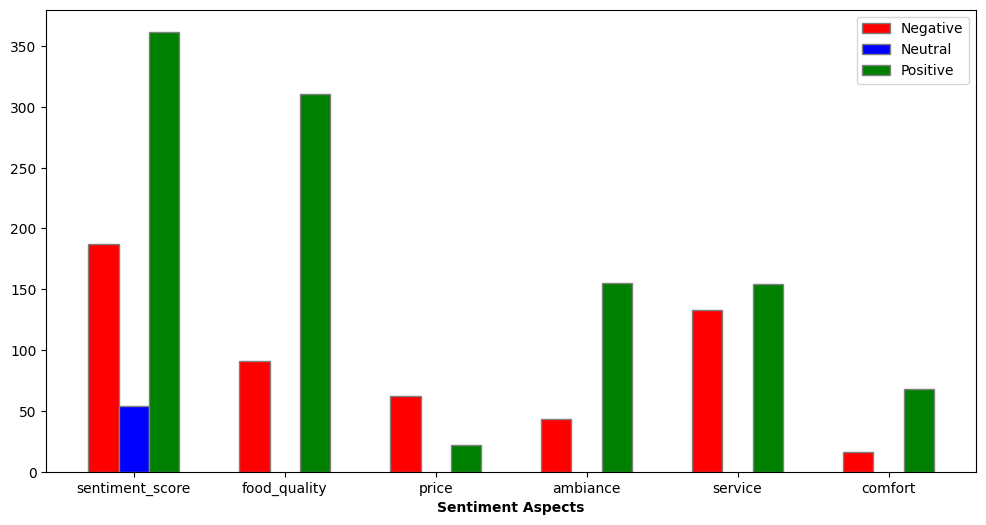

In [323]:
plot_business_metrics(business_final_metric, 'eMiN8nm70jjKg8izikVWDA')



In [325]:

business_final_metric.to_pickle('../src/data/business_final_metric.pkl')

In [326]:
restaurant_aspect=pickle.load(open('/Users/sairindhri/yelp-data-analysis2/src/data/business_final_metric.pkl','rb'))

index = np.where(restaurant_aspect.business_id=='eMiN8nm70jjKg8izikVWDA')[0][0]
target_row = restaurant_aspect.iloc[index]
print("index = {}".format(index))
sentiment_score=target_row['sentiment_score']
food_quality=target_row['food_quality']
price=target_row['price']
ambiance=target_row['ambiance']
service=target_row['service']
comfort=target_row['comfort']

index = 0


In [328]:
print(type(sentiment_score))

<class 'list'>


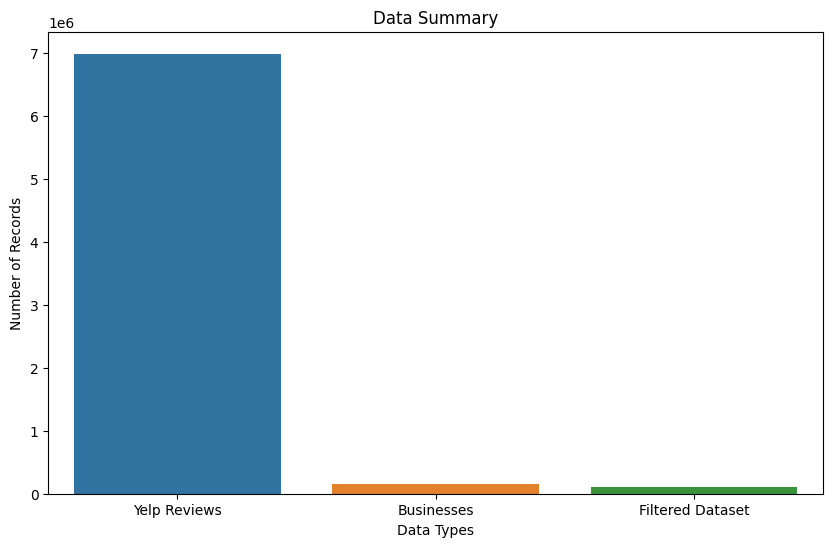

In [329]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define the data
review_count = 6990280
business_count = 150346
filtered_count = 100000

# Create the data for the bar plots
counts = [review_count, business_count, filtered_count]
labels = ['Yelp Reviews', 'Businesses', 'Filtered Dataset']

# Plot the bar plots
plt.figure(figsize=(10, 6))
sns.barplot(x=labels, y=counts)

# Customize the plot
plt.title('Data Summary')
plt.xlabel('Data Types')
plt.ylabel('Number of Records')

# Display the plot
plt.show()
